In [1]:
import pandas as pd
import os

BASE_DIR = "/Users/setti/Desktop/Battery_PINN_SOH/Simulation/data"

all_records = []

for cell in sorted(os.listdir(BASE_DIR)):
    cell_path = os.path.join(BASE_DIR, cell)
    if not os.path.isdir(cell_path):
        continue

    file_path = os.path.join(cell_path, "cycling_wExpansion.csv")
    if not os.path.exists(file_path):
        continue

    df = pd.read_csv(file_path)

    # discharge only
    df_dis = df[df["Current [mA]"] < 0]

    for cycle, g in df_dis.groupby("Cycle number"):
        q_dis = g["Capacity [Ah]"].abs().max()
        t_mean = g["Temperature [C]"].mean()

        all_records.append({
            "cell": cell,
            "cycle": cycle,
            "Q_dis": q_dis,
            "T_C": t_mean
        })

full_df = pd.DataFrame(all_records)


In [2]:
full_df["SOH"] = 0.0

for cell, g in full_df.groupby("cell"):
    Q0 = g.sort_values("cycle").iloc[0]["Q_dis"]
    full_df.loc[g.index, "SOH"] = g["Q_dis"] / Q0


In [3]:
import numpy as np
from scipy.optimize import least_squares

R = 8.314

N = full_df["cycle"].values
SOH_meas = full_df["SOH"].values
T_K = full_df["T_C"].values + 273.15

def soh_model(params, N, T):
    k, Ea = params
    return np.exp(-k * N * np.exp(-Ea / (R * T)))

def residuals(params):
    return soh_model(params, N, T_K) - SOH_meas

x0 = [1e-4, 3e4]  # k, Ea

res = least_squares(
    residuals,
    x0,
    bounds=([0, 1e4], [1, 1e5])
)

k_fit, Ea_fit = res.x

print("k =", k_fit)
print("Ea =", Ea_fit / 1000, "kJ/mol")


k = 0.025269617826815173
Ea = 10.000000000000103 kJ/mol


In [4]:
Ea_fixed = 3e4  # J/mol

def soh_model_konly(k, N, T):
    return np.exp(-k * N * np.exp(-Ea_fixed / (R * T)))

def residuals_konly(k):
    return soh_model_konly(k, N, T_K) - SOH_meas

from scipy.optimize import least_squares

res = least_squares(
    residuals_konly,
    x0=[1e-4],
    bounds=([0], [1])
)

k_fit = res.x[0]
print("k (Ea fixed) =", k_fit)


k (Ea fixed) = 0.9999999999999999


In [5]:
N_ref = full_df["cycle"].max()
N_scaled = full_df["cycle"].values / N_ref

def soh_model_scaled(k, N_scaled, T):
    return np.exp(-k * N_scaled * np.exp(-Ea_fixed / (R * T)))

def residuals_scaled(k):
    return soh_model_scaled(k, N_scaled, T_K) - SOH_meas

res = least_squares(
    residuals_scaled,
    x0=[1.0],
    bounds=([0], [100])
)

k_fit = res.x[0]
print("k (scaled cycles) =", k_fit)


k (scaled cycles) = 99.99999999999999


In [8]:
import numpy as np
from scipy.optimize import least_squares

R = 8.314
Ea_fixed = 3e4  # 30 kJ/mol in J/mol

N = full_df["cycle"].values.astype(float)
SOH_meas = full_df["SOH"].values.astype(float)
T_K = (full_df["T_C"].values.astype(float) + 273.15)

Tref = Tref = 25 + 273.15  # 25°C reference temperature


def temp_multiplier(T):
    # multiplier = exp( Ea/R * (1/Tref - 1/T) )
    return np.exp((Ea_fixed / R) * (1.0 / Tref - 1.0 / T))

def soh_model_kref(kref):
    return np.exp(-kref * N * temp_multiplier(T_K))

def residuals_kref(x):
    kref = x[0]
    return soh_model_kref(kref) - SOH_meas

# good initial guess from your data scale
kref0 = 1e-3

res = least_squares(
    residuals_kref,
    x0=[kref0],
    bounds=([0], [1])   # now kref should be small; 0..1 is plenty
)

kref_fit = res.x[0]
print("k_ref =", kref_fit)
print("Tref (C) =", Tref - 273.15)


k_ref = 0.00034303264348181867
Tref (C) = 25.0


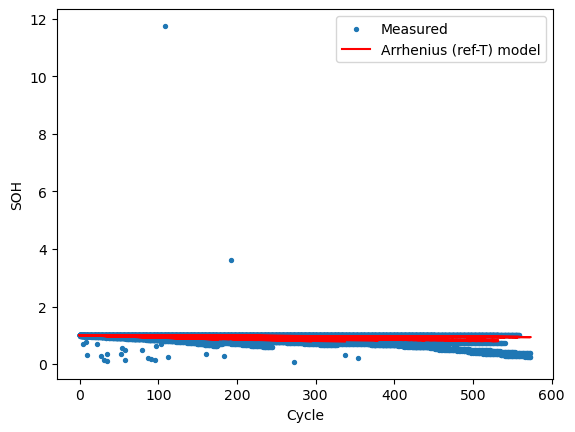

In [9]:
import matplotlib.pyplot as plt

SOH_pred = soh_model_kref(kref_fit)

plt.figure()
plt.scatter(N, SOH_meas, s=8, label="Measured")
plt.plot(N, SOH_pred, 'r', label="Arrhenius (ref-T) model")
plt.xlabel("Cycle")
plt.ylabel("SOH")
plt.legend()
plt.show()


In [10]:
SOH_pred = soh_model_kref(kref_fit)

rmse = np.sqrt(np.mean((SOH_pred - SOH_meas)**2))
print("RMSE(SOH) =", rmse)


RMSE(SOH) = 0.19225710595801374


In [11]:
def first_cycle_below(df_cell, col, thresh=0.8):
    df_cell = df_cell.sort_values("cycle")
    hit = df_cell[df_cell[col] <= thresh]
    if len(hit) == 0:
        return np.nan
    return int(hit.iloc[0]["cycle"])

full_df = full_df.copy()
full_df["SOH_pred"] = np.exp(-kref_fit * full_df["cycle"].values * temp_multiplier(full_df["T_C"].values + 273.15))

rows = []
for cell, g in full_df.groupby("cell"):
    n80_meas = first_cycle_below(g, "SOH", 0.8)
    n80_pred = first_cycle_below(g, "SOH_pred", 0.8)
    rows.append({"cell": cell, "N80_meas": n80_meas, "N80_pred": n80_pred})

life_df = pd.DataFrame(rows)
print(life_df.head())

# life error
life_df["abs_err"] = (life_df["N80_pred"] - life_df["N80_meas"]).abs()
print("Mean |N80 error| =", life_df["abs_err"].mean())


  cell  N80_meas  N80_pred
0   01      58.0       NaN
1   02      96.0       NaN
2   03       4.0       NaN
3   04     226.0       NaN
4   05     287.0       NaN
Mean |N80 error| = 229.0
